# Data Preparation

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
x = np.arange(3.1, 20, 0.2)

In [ ]:
# Наша функция
y = (np.sin(2*x) * x) + np.random.rand(x.size) * 0.2

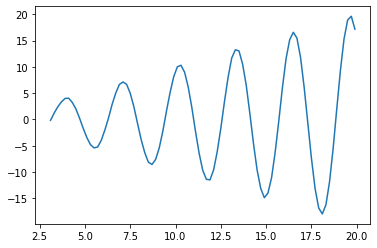

In [ ]:
plt.plot(x, y)

In [ ]:
len(x)

85

In [ ]:
raw_dataset = pd.DataFrame.from_dict(dict(zip(x.tolist(), y.tolist())), orient='index').reset_index()
raw_dataset.columns = ['x', 'y']
raw_dataset = raw_dataset[["y", "x"]]
raw_dataset.head(5)

,y,x
0,-0.165349,3.1
1,1.217487,3.3
2,2.404158,3.5
3,3.345047,3.7
4,3.996026,3.9


In [ ]:
def create_shifted_df(df,shift):
    shifted_df = pd.concat([df, df.shift(shift)[['y']]], axis=1)
    shifted_df.columns = ["y", "x", "y_"+str(shift)]
    shifted_df = shifted_df[["y_"+str(shift)]]
    return shifted_df.dropna()

In [ ]:
test_df = raw_dataset
for i in range(1, 6):
    test_df = pd.concat([test_df, create_shifted_df(raw_dataset, i)], axis=1)

In [ ]:
test_df = test_df.dropna()
test_df.head(5)

,y,x,y_1,y_2,y_3,y_4,y_5
5,4.047101,4.1,3.996026,3.345047,2.404158,1.217487,-0.165349
6,3.241412,4.3,4.047101,3.996026,3.345047,2.404158,1.217487
7,1.999863,4.5,3.241412,4.047101,3.996026,3.345047,2.404158
8,0.268352,4.7,1.999863,3.241412,4.047101,3.996026,3.345047
9,-1.643237,4.9,0.268352,1.999863,3.241412,4.047101,3.996026


In [ ]:
test_df.shape

(80, 7)

In [ ]:
test_df.tail(5)

,y,x,y_1,y_2,y_3,y_4,y_5
80,9.305892,19.1,2.052720,-5.453945,-11.832672,-16.220601,-17.938274
81,15.304517,19.3,9.305892,2.052720,-5.453945,-11.832672,-16.220601
82,18.910674,19.5,15.304517,9.305892,2.052720,-5.453945,-11.832672
83,19.614028,19.7,18.910674,15.304517,9.305892,2.052720,-5.453945
84,17.171458,19.9,19.614028,18.910674,15.304517,9.305892,2.052720


In [ ]:
y = test_df.y
y.head(3)

5    4.047101
6    3.241412
7    1.999863
Name: y, dtype: float64

In [ ]:
X = test_df.drop(['y'], axis=1)
X.columns = ["x","y1","y2","y3","y4","y5"]
X.head(3)

,x,y1,y2,y3,y4,y5
5,4.1,3.996026,3.345047,2.404158,1.217487,-0.165349
6,4.3,4.047101,3.996026,3.345047,2.404158,1.217487
7,4.5,3.241412,4.047101,3.996026,3.345047,2.404158


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)

In [ ]:
X_train.shape

(53, 6)

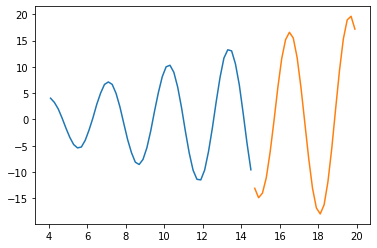

In [ ]:
plt.plot(X_train.x, y_train)
plt.plot(X_test.x, y_test)

# Modeling

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

In [ ]:
# [samples, time steps, features]
ds = tf.keras.preprocessing.timeseries_dataset_from_array(data=X_train.drop(['x'], axis=1), # x was droped
                                                     targets=y_train,
                                                    sequence_length=1)
x, y = next(iter(ds))
x.shape[1:]

TensorShape([1, 5])

In [ ]:
model = tf.keras.models.Sequential()
model.add(layers.LSTM(700, input_shape=x.shape[1:], activation='tanh', return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 700)            1976800   
_________________________________________________________________
dropout (Dropout)            (None, 1, 700)            0         
_________________________________________________________________
dense (Dense)                (None, 1, 1)              701       
Total params: 1,977,501
Trainable params: 1,977,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='mean_squared_error', optimizer="adam", metrics="mean_absolute_error")

In [ ]:
l_history = model.fit(x, y, epochs=7000)

# Evaluation

In [ ]:
y_pred = model.predict(X_test.drop('x', axis=1).to_numpy().reshape(X_test.shape[0],1,X_test.shape[1]-1)).reshape(X_test.shape[0])
y_pred

array([-12.671094  , -13.964843  , -13.579772  , -10.968188  ,
        -6.415969  ,  -0.35846546,   5.904522  ,  11.2642765 ,
        15.021201  ,  15.9130945 ,  14.894861  ,  11.553034  ,
         6.285661  ,  -0.64560974,  -7.623312  , -12.686525  ,
       -15.107612  , -15.826831  , -14.850017  , -11.664974  ,
        -5.781737  ,   1.8105255 ,   9.119691  ,  14.743664  ,
        17.751518  ,  17.975653  ,  16.027935  ], dtype=float32)

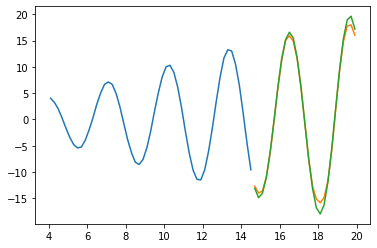

In [ ]:
plt.plot(X_train.x, y_train)
plt.plot(X_test.x, y_pred)
plt.plot(X_test.x, y_test)

# Validate

In [ ]:
# x_validate = np.arange(3.1, 30, 0.2)
# # Our function
# y_validate = (np.sin(2*x_validate) * x_validate) + np.random.rand(x_validate.size) * 0.2
# val_dataset = pd.DataFrame.from_dict(dict(zip(x_validate.tolist(), y_validate.tolist())), orient='index').reset_index()
# val_dataset.columns = ['x', 'y']
# val_dataset = val_dataset[["y", "x"]]
# test_val = val_dataset
# for i in range(1, 6):
#     test_val = pd.concat([test_val, create_shifted_df(val_dataset, i)], axis=1)
# test_val = test_val.dropna()
# val_df = test_val.tail(40)
# val_df.head(3)

In [ ]:
# y_val_pred = model.predict(val_df.drop(['y','x'], axis=1).to_numpy().reshape(val_df.shape[0],1,val_df.shape[1]-2)).reshape(val_df.shape[0])
# y_val_pred

In [ ]:
# plt.plot(test_val.x, test_val.y)
# plt.plot(val_df.x, y_val_pred)